In [1]:
"""
Visualization for topic modeling using Networkx

**TOPICS for 5 different eras** (Pre2003, 2003-2009, 2009-2012, 2012-2015, 2015-now)

nodes: topics + words
    - color: node['type'] = 'topic' / 'word'
    - size: degree centrality


edge: when value != 0 in topic_word df

"""

"\nVisualization for topic modeling using Networkx\n\n**TOPICS for 5 different eras** (Pre2003, 2003-2009, 2009-2012, 2012-2015, 2015-now)\n\nnodes: topics + words\n    - color: node['type'] = 'topic' / 'word'\n    - size: degree centrality\n\n\nedge: when value != 0 in topic_word df\n\n"

In [2]:
import re, itertools
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, count

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/katiehuang/Desktop/metis/projects/onl_ds5_project_4/py')
from word_cloud import *
import importlib

In [3]:
speech_df = pd.read_pickle('../dump/speech_clean_lemma')
topic_word = pd.read_pickle('../dump/to_nx_topic_words')

## 1. Load data
Import topic_df for 5 eras.

In [4]:
topic_df_1 = pd.read_pickle('../dump/to_nx_topic_df_1')
topic_df_2 = pd.read_pickle('../dump/to_nx_topic_df_2')
topic_df_3 = pd.read_pickle('../dump/to_nx_topic_df_3')
topic_df_4 = pd.read_pickle('../dump/to_nx_topic_df_4')
topic_df_5 = pd.read_pickle('../dump/to_nx_topic_df_5')

In [5]:
def topic_word_to_nx(topic_df):
    """
    Given the topic_df (rows: topic, columns: terms)
    Return a co-currence matrix where indices=columns=(topics+terms)
    that can be used in networkx or gephi for network analysis
    
    """
    topic_df['words'] = topic_df.apply(lambda x: " ".join(x.astype('str')),axis=1)
    topic_word = topic_df[['words']]
    data_dtm = cv_dtm(topic_word,'words')
    # Create topic-topic df to append
    topic_topic = pd.DataFrame(columns = data_dtm.index,index=data_dtm.index).fillna(0)
    concat_1 = pd.concat([topic_topic,data_dtm],axis=1)

    # Create word-word df to append
    word_word = pd.DataFrame(columns = concat_1.columns,index=data_dtm.columns).fillna(0)
    concat_2 = pd.concat([concat_1,word_word],axis=0)

    return concat_2

In [6]:
# Convert topic_df to topic_word for networkx
topic_word_1 = topic_word_to_nx(topic_df_1)
topic_word_2 = topic_word_to_nx(topic_df_2)
topic_word_3 = topic_word_to_nx(topic_df_3)
topic_word_4 = topic_word_to_nx(topic_df_4)
topic_word_5 = topic_word_to_nx(topic_df_5)

## 2. Draw networkx graph
Use curved edge style with node size depending on degree.

### A. Preparation

In [8]:
# Define function to create curved edge
def new_add_edge(G, a, b):
    if (a, b) in G.edges:
        max_rad = max(x[2]['rad'] for x in G.edges(data=True) if sorted(x[:2]) == sorted([a,b]))
    else:
        max_rad = 0
    G.add_edge(a, b, rad=max_rad+0.5)

In [15]:
def VizNx(topic_word, num_topic, title):
    """
    Given the topic_word dataframe, generate the networkx graph.
    
    """
    
    num_term = topic_word.shape[0] - num_topic
    
    # Prepare nodes
    node_list = list(topic_word.columns)

    # Prepare edges
    topic_word_assoc = {}

    relationships = itertools.combinations(node_list,2) 
    for relationship in relationships:
        topic_word_assoc[relationship] = topic_word.loc[relationship[0],relationship[1]]

    # Basic plot for pos_want   FOR TOPIC_DF_1
    # Create networkx graph

    G = nx.Graph()

    # Create nodes and edges
    for node in node_list:
        G.add_node(node)
    for edge, weight in topic_word_assoc.items():
        if weight != 0:
            G.add_edge(edge[0], edge[1], weight=weight)

    # Add attribute ('type') for node color
    for n, d in list(G.nodes(data=True))[:num_topic]:
        G.nodes[n]['type'] = 'topic'
    for n, d in list(G.nodes(data=True))[num_topic:]:
        G.nodes[n]['type'] = 'word'

    # Assign values to 'type' (if want to use 'type' as node size partition)
    types = ['topic','word']
    mapping = {'topic':5, 'word':0.5}
    nodes = G.nodes()
    node_label = [mapping[G.nodes[n]['type']] for n in nodes]

    # Draw
    plt.rcParams['figure.figsize'] = [20, 16]
    pos = nx.spring_layout(G, iterations=20, scale=2, k=0.1)             # position of nodes
#     nx.draw(G, pos, with_labels=True, font_size=16,                         # node label
#             node_color=node_label, cmap='Pastel1',                          # node colorr
#             nodelist = node_list, node_size=[v*6000 for v in node_label],  # mode size
#             width=.5, alpha=1,                                            # edge width and transparency
#             )

    # Memorize the node positions from basic plot
    pos_want = pos


    # Actual curved edge graph
    # Create graph
    G = nx.MultiDiGraph()

    # Add nodes
    for node in node_list:
        G.add_node(node)

    # Add edges
    for edge, weight in topic_word_assoc.items():
        if weight != 0:
            new_add_edge(G,edge[0],edge[1])

    # Add node attribute ('type')
    for n, d in list(G.nodes(data=True))[:num_topic]:
        G.nodes[n]['type'] = 'topic'
    for n, d in list(G.nodes(data=True))[num_topic:]:
        G.nodes[n]['type'] = 'word'

    # Quantify node label for size and color
    from itertools import count
    types = ['topic','word']
    mapping = {'topic':3, 'word':0.5}
    nodes = G.nodes()
    node_label = [mapping[G.nodes[n]['type']] for n in nodes]



#     # Draw
#     plt.rcParams['figure.figsize'] = [20, 16]
#     fig, ax = plt.subplots()

#     # Draw nodes and labels
#     nx.draw_networkx_nodes(G, pos=pos_want, node_color=node_label, cmap='Pastel1',
#             nodelist = node_list, node_size=[v*6000 for v in node_label],)
#     nx.draw_networkx_labels(G, pos=pos_want, font_size=16)

#     # Draw edges
#     for edge in G.edges(data=True):    
#         nx.draw_networkx_edges(G, pos=pos_want,
#                                edgelist=[(edge[0],edge[1])], connectionstyle=f'arc3, rad = {edge[2]["rad"]}',
#                                width=.3,edge_color='grey',arrowsize=1)

#     ax.axis('off');
    
    
    # Node different size
    
    plt.rcParams['figure.figsize'] = [20, 12]
    fig, ax = plt.subplots()

    # nodes customization
    degree_raw = list(nx.degree_centrality(G).values())
    alpha_list = [1]*num_topic + [0.6]*num_term

    # nodes
    degree = [d**1.15 for d in degree_raw]
    nx.draw_networkx_nodes(G, pos=pos_want, # post_want was saved from default plot
                           node_color=node_label, cmap='Pastel1', alpha= alpha_list,
                           nodelist = node_list, node_size=[v*200000 for v in degree],)
    # labels
    nx.draw_networkx_labels(G, pos=pos_want, font_size=16)



    # edges
    for edge in G.edges(data=True):    
        nx.draw_networkx_edges(G, pos=pos_want,
                               edgelist=[(edge[0],edge[1])], connectionstyle=f'arc3, rad = {edge[2]["rad"]}',
                               width=.3,edge_color='grey',arrowsize=1)
    ax.set_title(title, fontdict = {'fontsize': 28})
    ax.axis('off');

### B. Draw

In [32]:
# Specify num_topic (based on topic_df from topic_modeling_refine notebook)
num_topic = 4

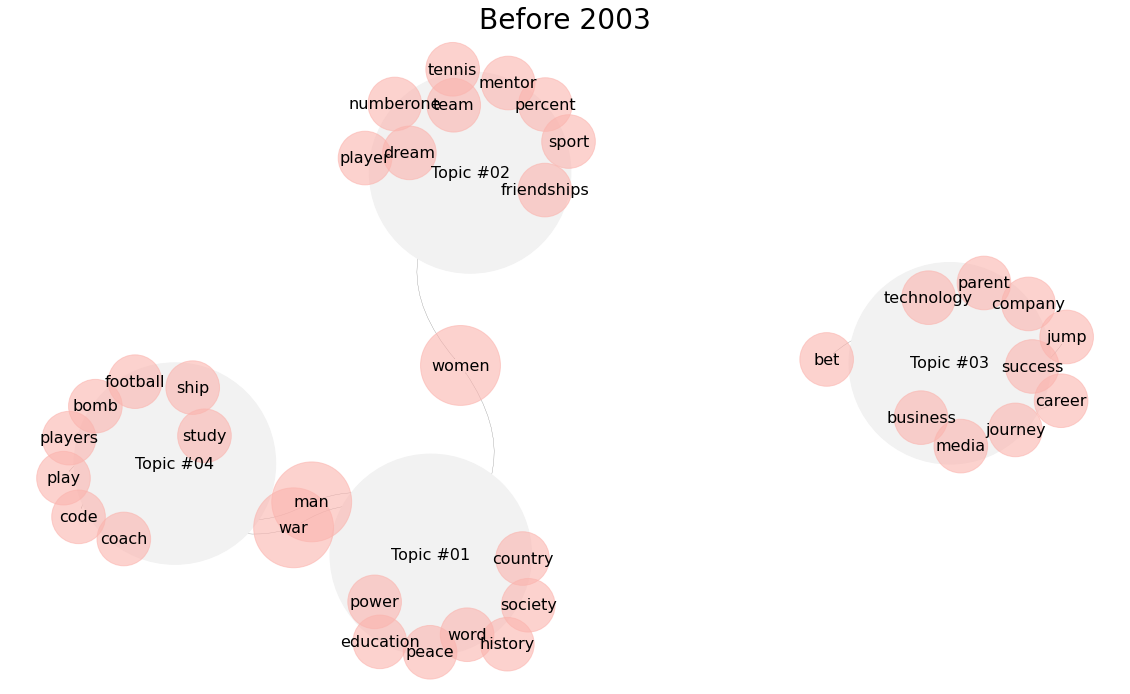

In [33]:
VizNx(topic_word_1,num_topic,'Before 2003')

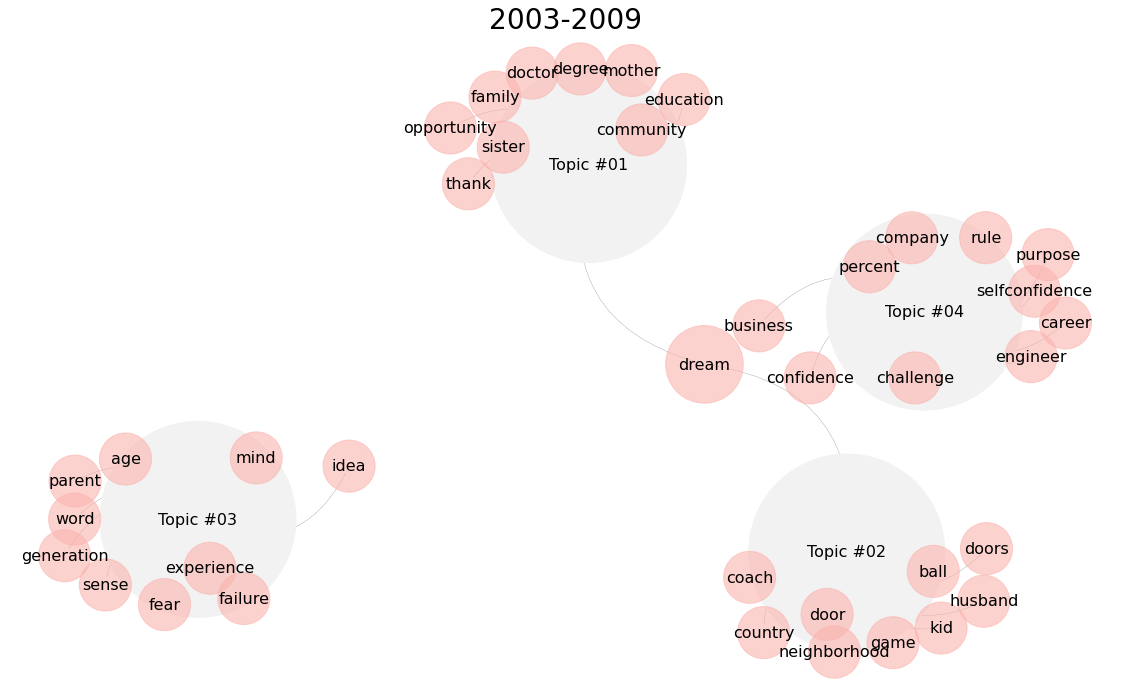

In [34]:
VizNx(topic_word_2,num_topic,'2003-2009')

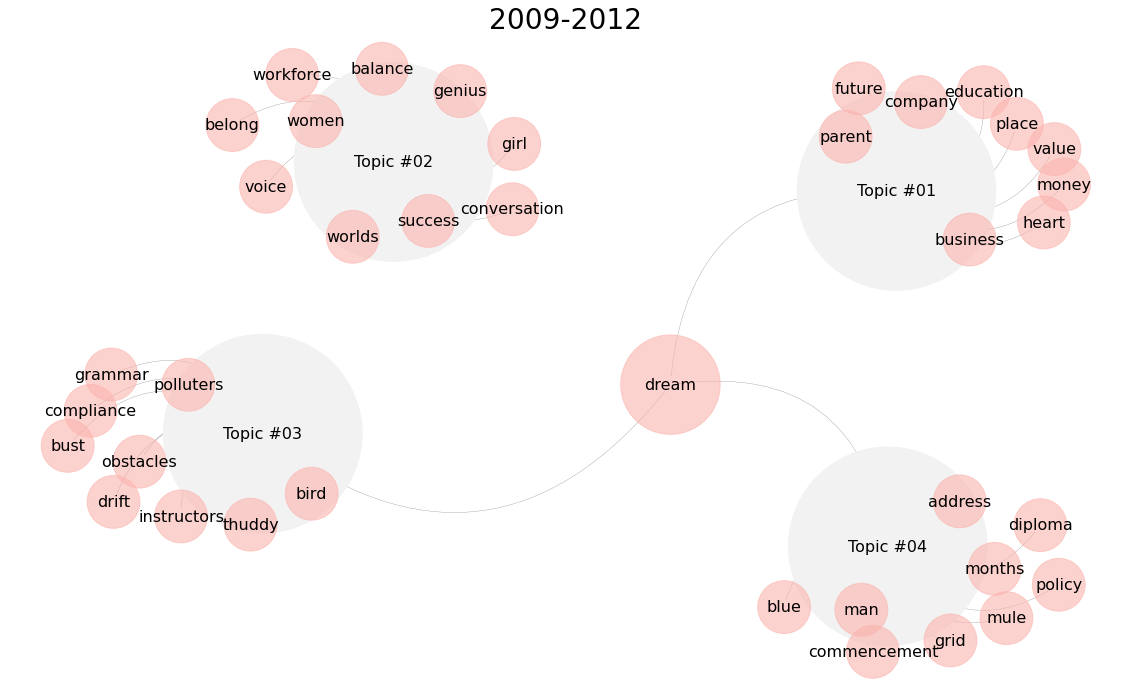

In [35]:
VizNx(topic_word_3,num_topic,'2009-2012')

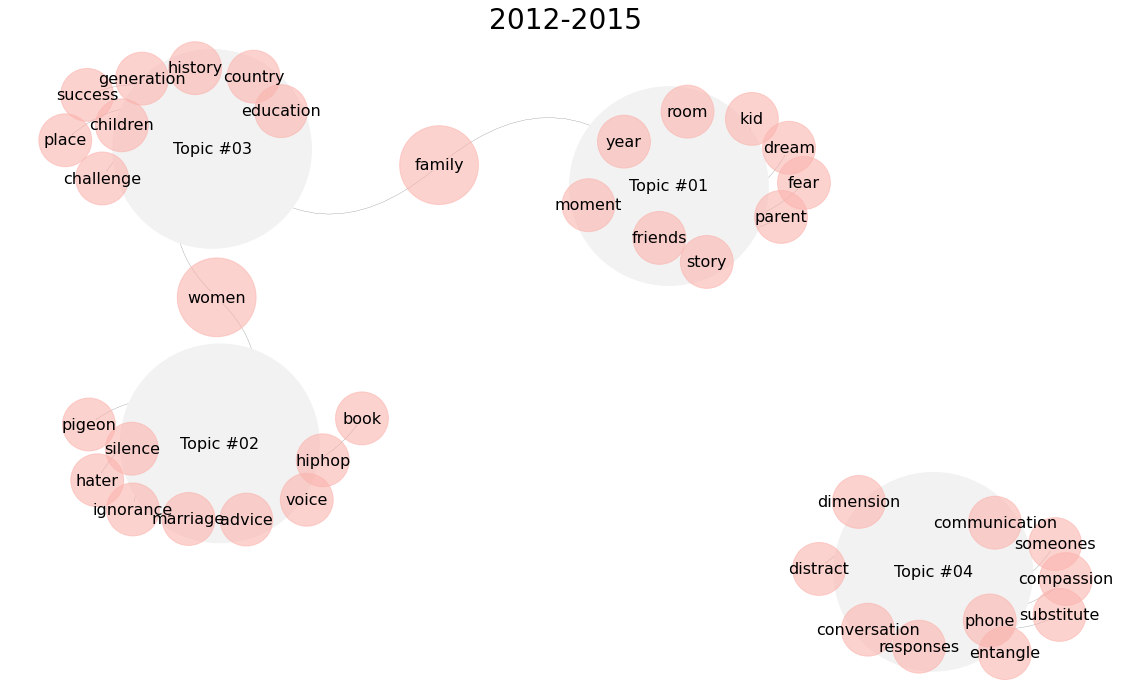

In [36]:
VizNx(topic_word_4,num_topic,'2012-2015')

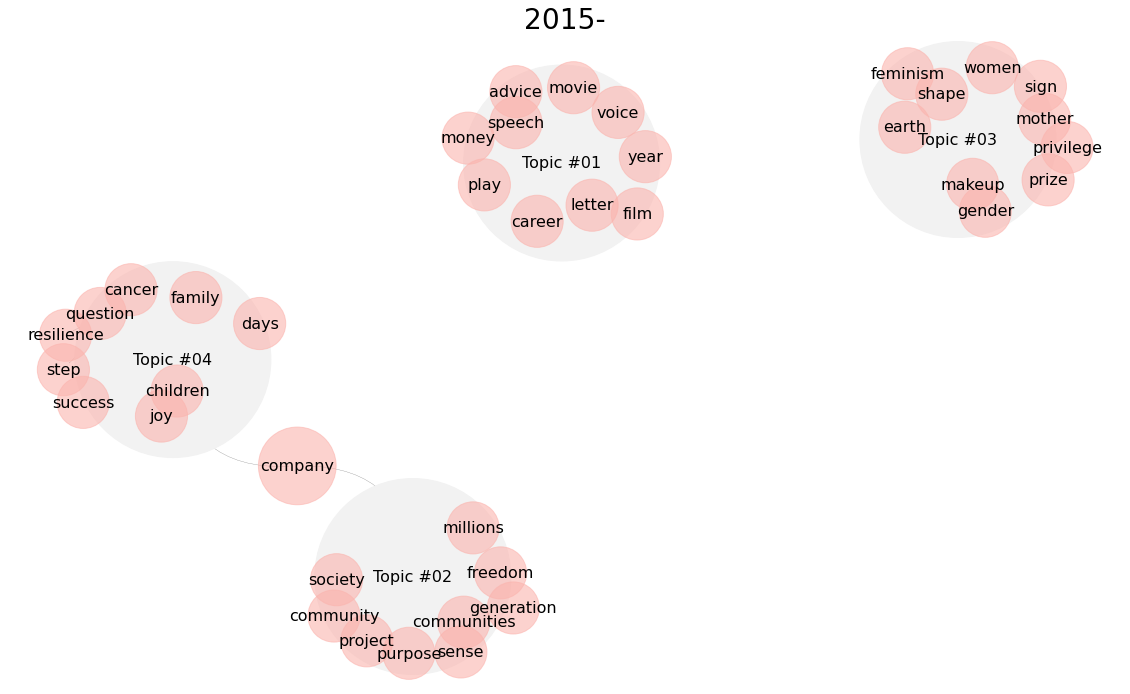

In [37]:
VizNx(topic_word_5,num_topic,'2015-')